In [1]:
import numpy as np
import numpy.testing as npt

from sklearn.metrics import accuracy_score

# Some auxiliary code 

In [2]:
class BasePredictionMatcher:
    def get_prediction_value(self, y):
        raise NotImplementedError

class ClassificationProbabilityMatcher(BasePredictionMatcher):
    def __init__(self, n_classes=None):
        self.n_classes = n_classes
    
    def get_prediction_value(self, y):
        """
        Parameters
        ----------
        y : numpy ndarray of shape (n_objects,) 
        
        Returns
        -------
        classes_probabilities : numpy ndarray of shape (n_classes,)
            classes_probabilities[i] - ith class probability
        """

        return np.bincount(y, minlength=self.n_classes) / y.size

In [3]:
some_y = np.array([1, 1, 2, 4, 2, 2, 0, 1, 0, 4])
probability_matcher = ClassificationProbabilityMatcher(n_classes=6)

assert probability_matcher.get_prediction_value(some_y).tolist() == [0.2, 0.3, 0.3, 0, 0.2, 0]

In [4]:
class BaseInformationCriterion:
    def find_best_split(self, X_feature, y):
        """
        Parameters
        ----------
        X_feature : numpy ndarray of shape (n_objects,)
        
        y : numpy ndarray of shape (n_objects,)
        
        Returns
        -------
        best_threshold : float 
        best_Q_value : float
        """
        possible_thresholds = sorted(list(set(X_feature)))[1:]
        H_all_X = self.get_H(y)
        
        best_threshold = None
        best_Q_value = -float('inf')
        
        for threshold in possible_thresholds:
            curr_mask = (X_feature >= threshold)
            y_left = y[~curr_mask]
            y_right = y[curr_mask]
            Q_value = self.get_Q(H_all_X, y_left, y_right)
            if Q_value > best_Q_value:
                best_Q_value = Q_value
                best_threshold = threshold

        return best_threshold, best_Q_value
        
        
    def get_Q(self, H_main, y_left, y_right):
        """
        Parameters
        ----------
        H_main : float
        
        y_left : numpy ndarray of shape (n_objects_left,)
        
        y_right : numpy ndarray of shape (n_objects_right,)
        
        Returns
        -------
        Q_value : float
        """
        total_L, total_R = len(y_left), len(y_right)
        total = total_L + total_R
        
        return H_main - self.get_H(y_left) * total_L / total - self.get_H(y_right) * total_R / total
        
    def get_H(self, y):
        raise NotImplementedError

In [5]:
class GeanyInformationCriterion(BaseInformationCriterion):
    def __init__(self, n_classes=None):
        self.probability_matcher = ClassificationProbabilityMatcher(n_classes=n_classes)
        
    def get_H(self, y):
        """
        Parameters
        ----------
        y : numpy ndarray of shape (n_objects,)
        
        Returns
        -------
        H_value : float
        """
        p = self.probability_matcher.get_prediction_value(y)
        return np.sum(p*(1 - p))

In [6]:
geany_criterion = GeanyInformationCriterion(n_classes=5)

main_H = geany_criterion.get_H(some_y)
npt.assert_almost_equal(main_H, 0.74, 4)

In [7]:
npt.assert_almost_equal(
    geany_criterion.get_Q(main_H, np.array([1, 1, 1, 0]), np.array([2, 2, 0, 2, 4, 4])),
    0.22333333333333327,
    decimal=4
)

In [8]:
some_X_feature = np.array([-5, -4, 1, 2, 3, 2, -3, -1, -2, 2])

best_threshold, best_Q = geany_criterion.find_best_split(some_X_feature, some_y)
assert best_threshold == 1
npt.assert_almost_equal(best_Q, 0.26, 4)

In [9]:
class TreeNode:
    def __init__(self, prediction_value, feature_index=None, threshold=None):
        self.feature_index = feature_index
        self.threshold = threshold
        self.prediction_value = prediction_value
        self.right_children = None
        self.left_children = None
        
    @property
    def is_terminal(self):
        if self.right_children is None and self.left_children is None:
            return True
        return False
    
    def get_next_nodes_mask(self, X):
        """
        Parameters
        ----------
        X : numpy ndarray of shape (n_objects, n_features)
        
        Returns
        -------
        next_node_indexes : numpy ndarray of shape (n_objects,)
        """
        feat = X[:, self.feature_index]
        ans = (feat >= self.threshold)

        return ans

        
    def split_node(self, X, y, criterion, prediction_matcher):
        """
        Parameters
        ----------
        X : numpy ndarray of shape (n_objects, n_features)
        y : numpy ndarray of shape (n_objects,)
        criterion : instance of BaseInformationCriterion inherited
        prediction_matcher : instance of BasePredictionMatcher inherited
        
        Returns
        -------
        indexes_mask : numpy ndarray of shape (n_objects,)
            Right children objects mask.
        right_children : instance of TreeNode
        left_children : instance of TreeNode
        """
        best_feature_index = None
        best_Q = -np.inf
        best_threshold = None
        
        for feature_index in range(X.shape[1]):
            feature_threshold, feature_Q = criterion.find_best_split(
                X[:, feature_index].ravel(), y
            )

            if feature_Q > best_Q:
                best_Q = feature_Q
                best_threshold = feature_threshold
                best_feature_index = feature_index

        self.feature_index = best_feature_index
        self.threshold = best_threshold
        indexes_mask = self.get_next_nodes_mask(X)
        right_pred_value = prediction_matcher.get_prediction_value(y[indexes_mask])
        left_pred_value = prediction_matcher.get_prediction_value(y[~indexes_mask])
        self.right_children = TreeNode(right_pred_value)
        self.left_children = TreeNode(left_pred_value)

        return indexes_mask, self.right_children, self.left_children

In [10]:
some_node = TreeNode(prediction_value=1, feature_index=0, threshold=0.5)

some_X = np.array([
    [0, 1, 2],
    [0.3, 1, 3],
    [0.5, 1, 3],
    [1, 2, 1]
])

some_y = np.array([0, 1, 1, 0])

assert some_node.get_next_nodes_mask(some_X).tolist() == [False, False, True, True]

In [11]:
some_node = TreeNode(1)
geany_criterion = GeanyInformationCriterion(n_classes=2)

In [12]:
mask, right_children, left_children = (
    some_node.split_node(some_X, some_y, geany_criterion, geany_criterion.probability_matcher)
)

assert mask.tolist() == [False, True, True, False]
assert right_children.prediction_value.tolist() == [0, 1]
assert left_children.prediction_value.tolist() == [1, 0]

# Decision tree class

In [13]:
class DecisionTree:
    def __init__(
        self, criterion, prediction_matcher,
        max_depth, min_leaf_size,
    ):
        self.max_depth = max_depth
        self.min_leaf_size = min_leaf_size
        self.criterion = criterion
        self.prediction_matcher = prediction_matcher
    
    def fit(self, X, y):
        """
        Parameters
        ----------
        X : numpy ndarray of shape (n_objects, n_features)
        y : numpy ndarray of shape (n_objects,)
        """
        base_answer = self.prediction_matcher.get_prediction_value(y)
        self.root_node = TreeNode(prediction_value=base_answer)
        self.tree = self._build_new_nodes(
            X, y, np.arange(y.shape[0]), self.root_node, 0
        )
        
        return None
        
    def _build_new_nodes(self, X, y, current_objects_indexes, current_node, current_depth):
        """
        Parameters
        ----------
        X : numpy ndarray of shape (n_objects, n_features)
        y : numpy ndarray of shape (n_objects,)
        current_objects_indexes : numpy ndarray of shape (n_objects_node,)
            Indexes of current node objects
        current_node : instance of TreeNode
        current_depth : int
        """
        try:
            assert (len(current_objects_indexes) > self.min_leaf_size)
            assert (current_depth < self.max_depth)
            assert len(np.unique(y) > 1)

            mask, right_child, left_child = \
                current_node.split_node(X, y, self.criterion, self.criterion.probability_matcher)

            right_child = self._build_new_nodes(
                X[mask], y[mask], np.where(mask)[0], right_child, current_depth+1
            )

            left_child = self._build_new_nodes(
                X[~mask], y[~mask], np.where(~mask)[0], left_child, current_depth+1
            )

        except AssertionError:
            counts = np.bincount(y, minlength=self.prediction_matcher.n_classes)
            prob = counts / y.shape[0]
            leaf = {
                'is_leaf': True,
                'prob': prob
            }
            return leaf

        node = {
            'is_leaf': False,
            'left': left_child,
            'right': right_child,
            'split_col': current_node.feature_index,
            'threshold': current_node.threshold
        }

        return node
        
        
    def predict(self, X):
        """
        Parameters
        ----------
        X : numpy ndarray of shape (n_objects, n_features)
        """
        predictions = np.zeros((X.shape[0], self.prediction_matcher.n_classes))

        for i in range(X.shape[0]):
            predictions[i] = self._get_predictions_from_terminal_nodes(X[i, :], self.tree)

        return predictions

    def _get_predictions_from_terminal_nodes(self, current_row, current_node):
        """
        Parameters
        ----------
        current_row : numpy ndarray of shape (n_features,)
        current_node : instance of TreeNode
        """
        if current_node['is_leaf']:
            return current_node['prob']

        elif current_row[current_node['split_col']] < current_node['threshold']:
            return self._get_predictions_from_terminal_nodes(
                current_row, current_node['left']
            )

        else:
            return self._get_predictions_from_terminal_nodes(
                current_row, current_node['right']
            )

In [14]:
class ClassificationDecisionTree(DecisionTree):
    def __init__(self, max_depth, min_leaf_size):
        criterion = GeanyInformationCriterion()
        matcher = ClassificationProbabilityMatcher()
        
        super().__init__(
            max_depth=max_depth,
            min_leaf_size=min_leaf_size,
            criterion=criterion,
            prediction_matcher=matcher,
        )
        
    def fit(self, X, y):
        n_classes = y.max() + 1
        self.prediction_matcher.n_classes = n_classes
        
        super().fit(X, y)
    
    def predict_proba(self, X):
        return super().predict(X)
    
    def predict(self, X):
        probabilities = super().predict(X)
        return np.argmax(probabilities, axis=1)

In [15]:
some_tree = ClassificationDecisionTree(max_depth=2, min_leaf_size=1)

some_X = np.vstack((
    np.random.normal(loc=(-5, -5), size=(100, 2)),
    np.random.normal(loc=(-5, 5), size=(100, 2)),
    np.random.normal(loc=(5, -5), size=(100, 2)),
    np.random.normal(loc=(5, 5), size=(100, 2)),
))

some_y = np.array(
    [0] * 100 + [1] * 100 + [2] * 100 + [3] * 100
)

some_tree.fit(some_X, some_y)
predictions = some_tree.predict(some_X)

In [16]:
assert isinstance(predictions, type(np.zeros(0)))
npt.assert_equal(predictions, some_y)

## Visualize the results

In [17]:
from sklearn.datasets import make_blobs

import matplotlib.pyplot as plt
%matplotlib inline

In [18]:
def plot_data(X, y, figsize=(6, 5)):
    plt.figure(figsize=figsize)
    
    n_classes = y.max() + 1
    for i in range(n_classes):
        plt.plot(X[:, 0][y == i], X[:, 1][y == i], 'o')

In [19]:
def plot_decision_surface(clf, X, y, plot_step=0.2, cmap='Spectral', figsize=(6, 5)):
    # Plot the decision boundary
    plt.figure(figsize=figsize)
    
    n_classes = len(set(y))
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                         np.arange(y_min, y_max, plot_step))

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    cs = plt.contourf(xx, yy, Z, cmap=cmap, alpha=0.5)    
    y_pred = clf.predict(X)

    # Plot the training points
    plt.scatter(*X[y_pred == y].T, marker='.', s=70,
                c=y[y_pred == y], cmap=cmap, alpha=0.9, label='correct')
    plt.scatter(*X[y_pred != y].T, marker='x', s=50,
                c=y[y_pred != y], cmap=cmap, label='errors')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.axis("tight")
    plt.legend(loc='best')
    print("Accuracy =", accuracy_score(y, y_pred))

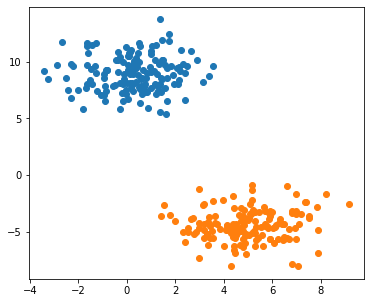

In [20]:
X, y = make_blobs(n_samples=300, n_features=2, cluster_std=1.5, centers=2, random_state=23)

plot_data(X, y)

In [21]:
some_tree = ClassificationDecisionTree(max_depth=1, min_leaf_size=1)
some_tree.fit(X, y)

Accuracy = 1.0


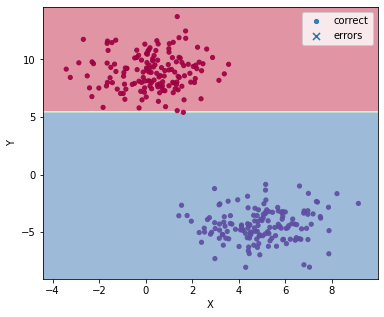

In [22]:
plot_decision_surface(some_tree, X, y)

In [23]:
X, y = make_blobs(n_samples=300, n_features=2, cluster_std=2, centers=5, random_state=23)

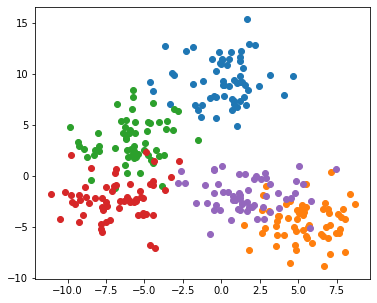

In [24]:
plot_data(X, y)

Accuracy = 0.4


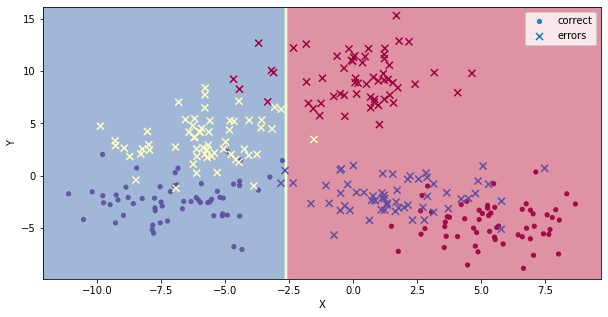

In [25]:
some_tree = ClassificationDecisionTree(max_depth=1, min_leaf_size=1)
some_tree.fit(X, y)

plot_decision_surface(some_tree, X, y, figsize=(10, 5))

Accuracy = 0.7466666666666667


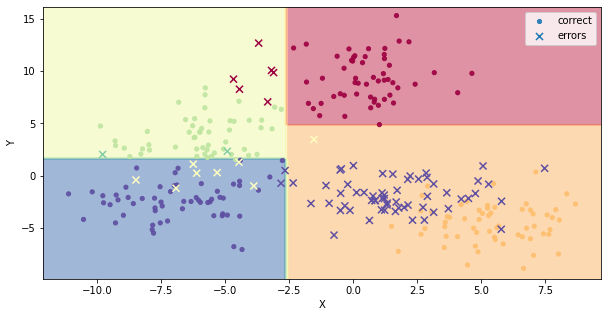

In [26]:
some_tree = ClassificationDecisionTree(max_depth=2, min_leaf_size=1)
some_tree.fit(X, y)

plot_decision_surface(some_tree, X, y, figsize=(10, 5))

Accuracy = 0.89


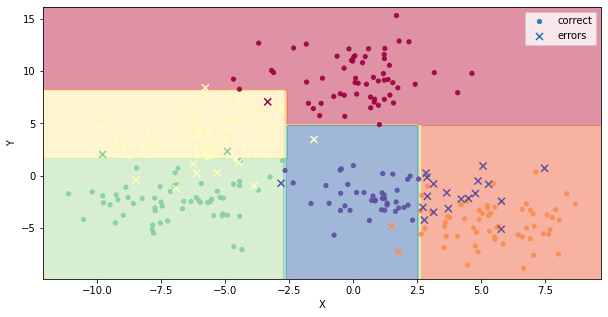

In [27]:
some_tree = ClassificationDecisionTree(max_depth=3, min_leaf_size=1)
some_tree.fit(X, y)

plot_decision_surface(some_tree, X, y, figsize=(10, 5))

Accuracy = 0.94


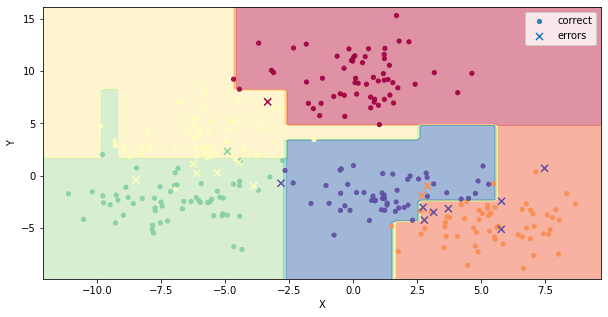

In [28]:
some_tree = ClassificationDecisionTree(max_depth=5, min_leaf_size=1)
some_tree.fit(X, y)

plot_decision_surface(some_tree, X, y, figsize=(10, 5))

Accuracy = 1.0


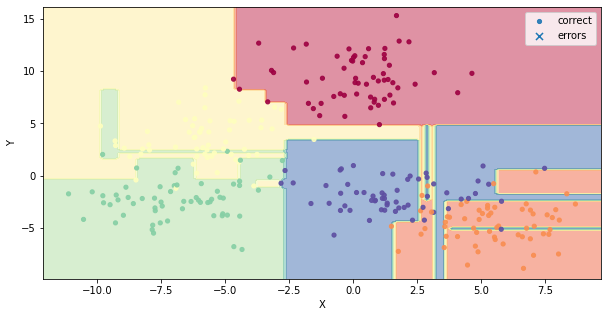

In [29]:
some_tree = ClassificationDecisionTree(max_depth=10, min_leaf_size=1)
some_tree.fit(X, y)

plot_decision_surface(some_tree, X, y, figsize=(10, 5))

Accuracy = 0.9466666666666667


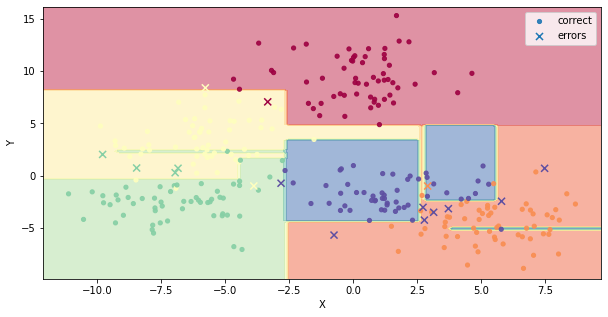

In [30]:
some_tree = ClassificationDecisionTree(max_depth=10, min_leaf_size=10)
some_tree.fit(X, y)

plot_decision_surface(some_tree, X, y, figsize=(10, 5))